In [1]:
import os
import pandas as pd
import copernicusmarine
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
from pandas.plotting import scatter_matrix

sns.set_style("whitegrid")

## Datasets

Importing datasets from we have discussed from copernicus 

In [2]:
dataset_ox = copernicusmarine.open_dataset(dataset_id ="cmems_mod_glo_bgc-bio_anfc_0.25deg_P1M-m")
dataset_chl = copernicusmarine.open_dataset(dataset_id = 'cmems_mod_glo_bgc-pft_anfc_0.25deg_P1M-m')
dataset_chm = copernicusmarine.open_dataset(dataset_id = 'cmems_mod_glo_bgc-nut_anfc_0.25deg_P1M-m')

INFO - 2024-08-07T15:12:14Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-07T15:12:14Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-07T15:12:19Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-08-07T15:12:32Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-07T15:12:32Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-07T15:12:38Z - Service was not specified, the default one was selected: "arco-geo-series"
INFO - 2024-08-07T15:12:50Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-07T15:12:50Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-07T15:12:56Z - Service was not specified, the default one was selected: "arco-geo-series"


Slicing for a `month` and `latitude`,`longitude` (for simplicity just a month and small area) 

In [3]:
ds_ox = dataset_ox.sel(time = slice('2022-07-01', '2022-07-02'),latitude = slice(53, 56.0),longitude = slice(2.5,9.25), depth = slice(0,2.521141e+01))
ds_chl = dataset_chl.sel(time = slice('2022-07-01', '2022-07-02'),latitude = slice(53, 56.0),longitude = slice(2.5,9.25),depth = slice(0,2.521141e+01))
ds_chm = dataset_chm.sel(time = slice('2022-07-01', '2022-07-02'), latitude = slice(53, 56.0),longitude = slice(2.5,9.25),depth = slice(0,2.521141e+01))

 Combining all into a single dataset by coordinates `['latitude','longitude',"time",'depth']`. I dropped `NaNs`.

In [4]:
combined_ds = xr.combine_by_coords([ds_ox, ds_chl, ds_chm ], coords=['latitude','longitude',"time",'depth']
                                , join="inner",combine_attrs = 'drop_conflicts')

Export to pandas (note that this takes some time)

In [5]:
pd_df = combined_ds.to_dataframe().dropna().reset_index()
#pd_df.to_csv("out.csv") # turn this on to save the  into local

## Exploration Plots

First, the scatter plots for between all variables of the dataset (for a fixed `depth`). Here we see relation between `chl`-`phyc` is nearly perfect linear, (probably because one of them is derived from the other ?) so we are not going to use `phyc` as a feature. Also the its interesting to see the functional realtion between `po4`-`si`, `po4`-`fe`.

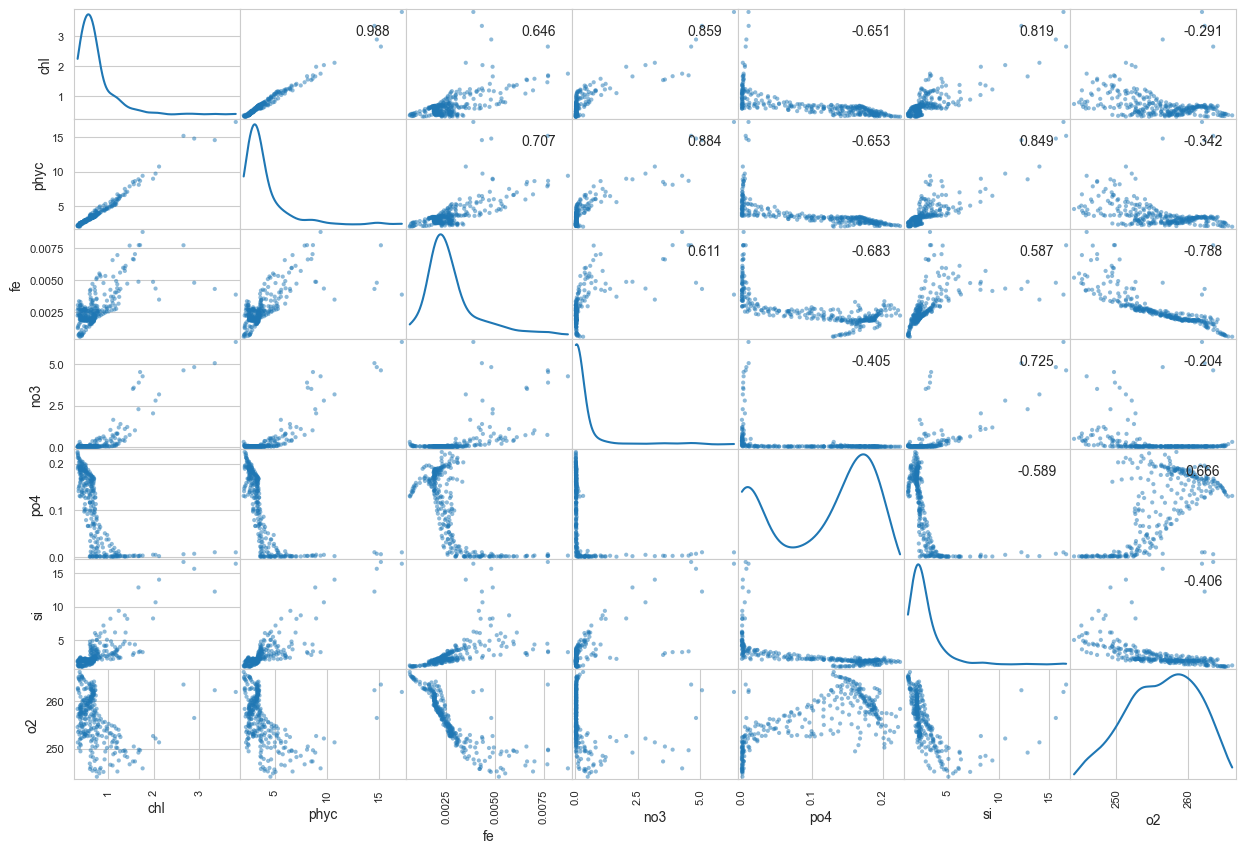

In [6]:
pd_df_0 = pd_df.loc[pd_df['depth']== pd_df['depth'][0] ]
axes = scatter_matrix(pd_df_0[['chl','phyc','fe', 'no3', 'po4','si','o2']], alpha=0.5,figsize=(15, 10), diagonal='kde')
corr = pd_df_0[['chl','phyc','fe', 'no3', 'po4','si','o2']].corr().to_numpy()
for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
    axes[i, j].annotate("%.3f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
plt.show()

One other potential plot of interest is a pairplot, here I plotted `chl` vs other features using `hue = 'depth'`

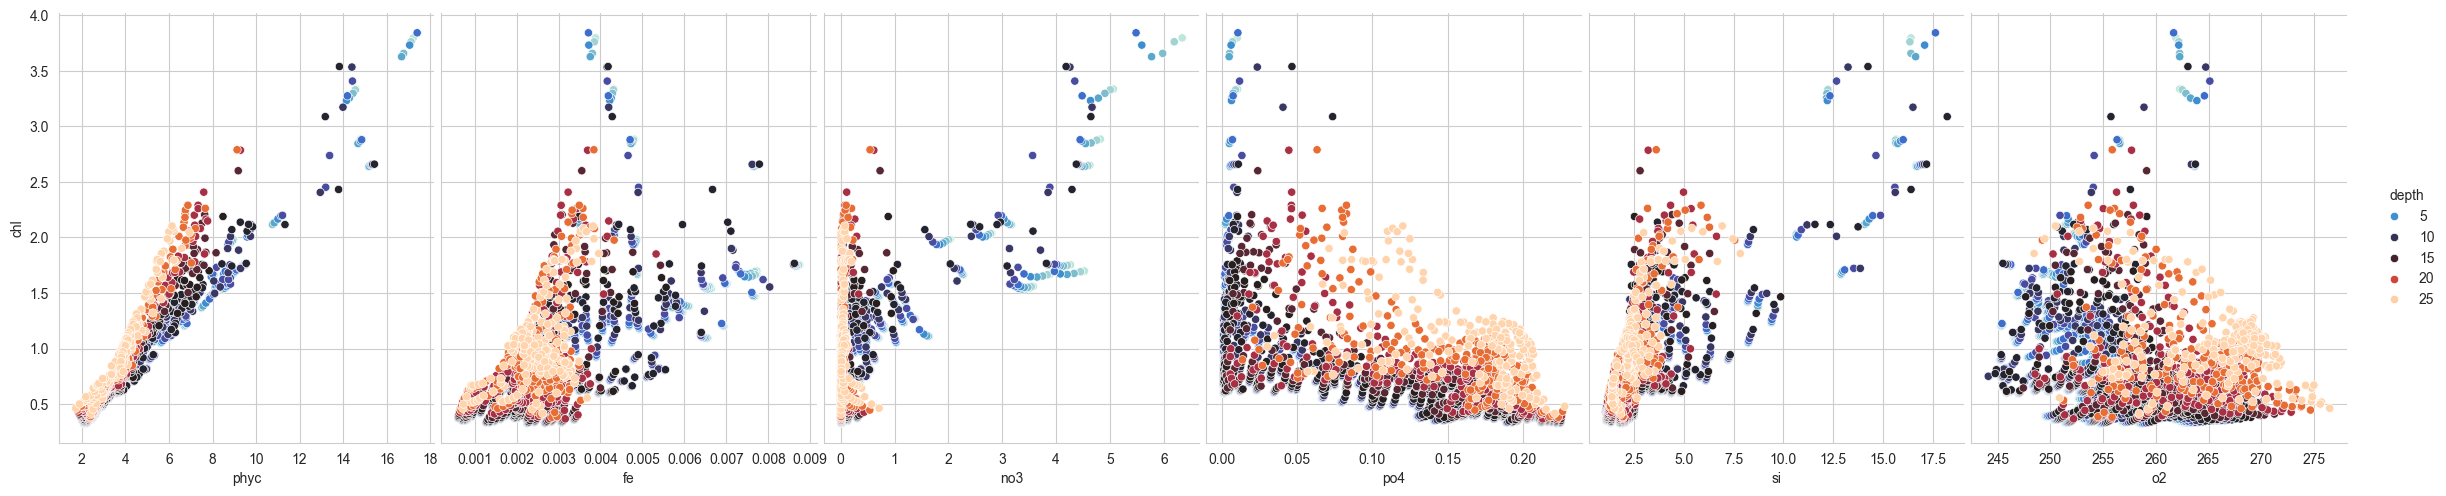

In [7]:
sns.pairplot(
                data= pd_df,
                x_vars=['phyc','fe', 'no3', 'po4','si','o2'],
                y_vars=['chl'],hue = 'depth',palette='icefire'
            , height=5, aspect=0.8)
plt.show()

<Axes: >

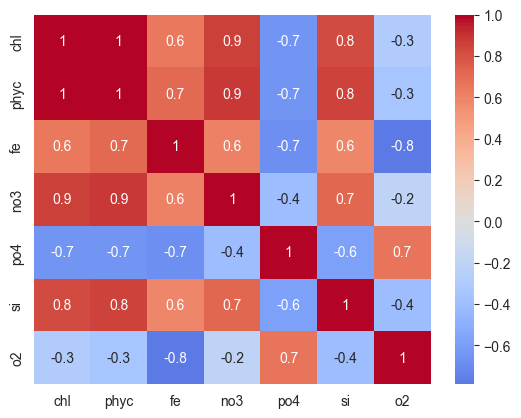

In [8]:
#another correlation plot
corr_matrix = pd.DataFrame(pd_df_0[['chl','phyc','fe', 'no3', 'po4','si','o2']].values, columns=['chl','phyc','fe', 'no3', 'po4','si','o2']).corr()
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".1g")

Again it is easy to see the high correlation between `chl`-`phyc`.

## Some simple models

In [9]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [10]:
chl_train, chl_test = train_test_split(pd_df.copy(), shuffle = True, test_size = .2,random_state= 131)
features = chl_train.columns[6:].to_list()

### Lasso regression

We start with the Lasso and see the feature importance for the feature set. For this first create train-test split using the feature set `['fe', 'no3', 'po4', 'si', 'nppv', 'o2']`. Note that we threw away `phyc`.

In [11]:
alphas = [0.00001,0.0001,0.001,0.005,0.0075,0.01,0.015,0.05,0.1,1,10,100,1000] # Lasso coefficients
                

## make coefficient holder
coefs = np.zeros((len(alphas), len(features)))

## scale quantitative variables
chl_train_array = chl_train[features].to_numpy()

scaler = StandardScaler()

## The features that need to be scaled
scale_columns = np.arange(len(features))
chl_train_array_scaled = chl_train_array.copy()
chl_train_array_scaled[:,scale_columns] = scaler.fit_transform(chl_train_array_scaled[:,scale_columns])


## Loop through alphas
for i in range(len(alphas)):
    ## make lasso model
    lasso = Lasso(alpha=alphas[i], max_iter=10000000)
    
    
    ## fit model
    lasso.fit(chl_train_array_scaled, chl_train.chl.values)
    
    ## record coefs
    coefs[i,:] = lasso.coef_

df_lass = pd.DataFrame(data=coefs, index=alphas, columns=features) # a table for the Lasso coefficients
df_lass    

,fe,no3,po4,si,nppv,o2
0.00001,0.208662,-0.033160,-0.123896,0.118886,0.158110,0.236830
0.00010,0.207935,-0.032397,-0.123847,0.118600,0.157883,0.236151
0.00100,0.200787,-0.024750,-0.123371,0.115669,0.155604,0.229426
0.00500,0.173634,-0.000000,-0.119073,0.105610,0.149689,0.201897
0.00750,0.164438,0.000000,-0.113045,0.104429,0.152846,0.188882
0.01000,0.155241,0.000000,-0.107018,0.103248,0.156003,0.175867
0.01500,0.136838,0.000000,-0.094962,0.100895,0.162315,0.149832
0.05000,0.023705,0.014708,-0.028026,0.081021,0.188302,0.000000
0.10000,0.009525,0.000000,-0.004826,0.072754,0.175635,0.000000
1.00000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000


From the Lasso coefficient table we find the first value of `alpha` where the parameter for the feature was set to zero. 

In [12]:
print(df_lass.ne(0).idxmin().sort_values(ascending=False))

fe      1.000
po4     1.000
si      1.000
nppv    1.000
o2      0.050
no3     0.005
dtype: float64


### Linear Regression

In [13]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error

Below `powerset()` function will create all possible subset of the features and then we apply linear regression on them to see which model has the lowest cross-validation mse.

In [14]:
# This returns the power set of a set minus the empty set
def powerset(s):
    power_set = []
    x = len(s)
    for i in range(1 << x):
        power_set.append([s[j] for j in range(x) if (i & (1 << j))])
        
    return power_set[1:]

In [15]:
kfold = KFold(n_splits=5, 
              shuffle=True, 
              random_state = 186)

In [16]:
## get all models we're interested in
models = powerset(features)


## This is the baseline model
models.append("baseline")


## make empty mse holder
cv_rmses = np.zeros((5, len(models)))



## loop through all splits
i = 0
for train_index, test_index in kfold.split(chl_train):
    ## get train and holdout sets
    chl_train_train = chl_train.iloc[train_index]
    chl_holdout = chl_train.iloc[test_index]


    ## loop through all models
    j = 0
    for model in models:
        if model == "baseline":
            chl_train_train_mean = chl_train_train.chl.mean()
            predict = chl_train_train_mean * np.ones(len(chl_holdout))
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        else:
            ## make clone
            reg = LinearRegression(copy_X = True)
        
        
            ## fit clone
            reg.fit(chl_train_train[model], chl_train_train.chl)
            predict = reg.predict(chl_holdout[model])

            ## record mse
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        j=j+1
    i=i+1  

The results of Linear regression:

In [17]:
## Which model had the smallest avg cv rmse?
m_model_lr = models[np.argmin(np.mean(cv_rmses, axis=0))]
m_model_lr_rmse = np.mean(cv_rmses, axis=0)[np.argmin(np.mean(cv_rmses, axis=0))]
print(f"The model with lowest mean cv rmse included the features, {m_model_lr},\n" 
      f"and had an avg cv rmse of, {m_model_lr_rmse}.")

The model with lowest mean cv rmse included the features, ['fe', 'no3', 'po4', 'si', 'nppv', 'o2'],
and had an avg cv rmse of, 0.19102026856459398.


In [18]:
## Rmse for the test set
reg_test = LinearRegression(copy_X = True)
reg_test.fit(chl_train[m_model_lr],chl_train.chl)
reg_pre = reg_test.predict(chl_test[m_model_lr])
reg_test_rsme = root_mean_squared_error(chl_test.chl,reg_pre)
print(f"Linear regression has test rmse of {reg_test_rsme}.")

Linear regression has test rmse of 0.2056107753167126.


In [19]:
# Baseline model mean cv rmse
base_av_rmse = np.mean(cv_rmses, axis=0)[-1]
print(f"Baseline model has cv rmse of {base_av_rmse}.")

Baseline model has cv rmse of 0.4230521960982416.


In [20]:
chl_test_mean = chl_test.chl.mean()
base_test_rmse = root_mean_squared_error(chl_test.chl,np.ones(len(chl_test.chl))*chl_test_mean) 
print(f"Baseline model has test rmse of {base_test_rmse}.")

Baseline model has test rmse of 0.44833180456238314.


### XgBoost

In [21]:
## import xgboost
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [22]:
# Define model
model_XG = xgb.XGBRegressor()
# Define the parameter grid to search over
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [300, 400, 500]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator = model_XG, param_grid = param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(chl_train[features], chl_train.chl)

# Get the best parameters
best_params_XG = grid_search.best_params_
print(f"Best Parameters: {best_params_XG}")

Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


Following `GridSearch`  we choose `'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500`

In [23]:
## make empty mse holder
cv_rmses = np.zeros((5, len(models)))

## loop through all splits
i = 0
for train_index, test_index in kfold.split(chl_train):
    ## get train and holdout sets
    chl_train_train = chl_train.iloc[train_index]
    chl_holdout = chl_train.iloc[test_index]


    ## loop through all models
    j = 0
    for model in models:
        if model == "baseline":
            chl_train_train_mean = chl_train_train.chl.mean()
            predict = chl_train_train_mean * np.ones(len(chl_holdout))
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        else:
            ## make clone
            xgb_reg = xgb.XGBRegressor(**best_params_XG)
        
        
            ## fit clone
            xgb_reg.fit(chl_train_train[model], chl_train_train.chl,
                   eval_set=[(chl_holdout[model], chl_holdout.chl)], verbose=False)
            

            ## record mse
            cv_rmses[i,j] = np.min(xgb_reg.evals_result()['validation_0']['rmse'])
        j=j+1
    i=i+1  

Results of XgBoost: 

In [24]:
m_model_xg = models[np.argmin(np.mean(cv_rmses, axis=0))]
m_model_xg_rmse = np.mean(cv_rmses, axis=0)[np.argmin(np.mean(cv_rmses, axis=0))]
print(f"The model with lowest mean cv rmse included the features, {m_model_xg}, \n"
      f"and had an avg cv rmse of, {m_model_xg_rmse}")

The model with lowest mean cv rmse included the features, ['fe', 'no3', 'po4', 'si', 'nppv', 'o2'], 
and had an avg cv rmse of, 0.06905091173545388


In [25]:
xgb_test = xgb.XGBRegressor(**best_params_XG)
xgb_test.fit(chl_train[m_model_xg],chl_train.chl)
xgb_pre = xgb_test.predict(chl_test[m_model_xg])
xgb_test_rsme = root_mean_squared_error(chl_test.chl,xgb_pre)
print(f"XgB has test rmse of {xgb_test_rsme}.")

XgB has test rmse of 0.07778231694056388.


### Linear Support Vector Regressor

In [26]:
## import LinearSVR
from sklearn.svm import SVR

In [27]:
# Define model
model_SVR = SVR()
# Define the parameter grid to search over
param_grid = {
    'gamma': [3, 5, 10],
    }

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator = model_SVR, param_grid = param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(chl_train[features], chl_train.chl)

# Get the best parameters
best_params_SVR = grid_search.best_params_
print(f"Best Parameters: {best_params_SVR}")

Best Parameters: {'gamma': 3}


For LSVR we choose `gamma = 3`.

In [28]:
## make empty rmse holder
cv_rmses = np.zeros((5, len(models)))



## loop through all splits
i = 0
for train_index, test_index in kfold.split(chl_train):
    ## get train and holdout sets
    chl_train_train = chl_train.iloc[train_index]
    chl_holdout = chl_train.iloc[test_index]


    ## loop through all models
    j = 0
    for model in models:
        if model == "baseline":
            chl_train_train_mean = chl_train_train.chl.mean()
            predict = chl_train_train_mean * np.ones(len(chl_holdout))
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        else:
            ## make clone
            reg = SVR(**best_params_SVR)
        
        
            ## fit clone
            reg.fit(chl_train_train[model], chl_train_train.chl)
            predict = reg.predict(chl_holdout[model])

            ## record mse
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        j=j+1
    i=i+1  

The results of Linear Support Vector Regressor:

In [29]:
m_model_svr = models[np.argmin(np.mean(cv_rmses, axis=0))]
m_model_svr_rmse = np.mean(cv_rmses, axis=0)[np.argmin(np.mean(cv_rmses, axis=0))]
print(f"The model with lowest mean cv rmse included the features, {m_model_svr}, \n"
      f"and had an avg cv rmse of, {m_model_svr_rmse}")

The model with lowest mean cv rmse included the features, ['no3', 'po4', 'si', 'o2'], 
and had an avg cv rmse of, 0.19425917154076228


In [30]:
svr_test = SVR(**best_params_SVR)
svr_test.fit(chl_train[m_model_svr],chl_train.chl)
svr_pre = svr_test.predict(chl_test[m_model_svr])
svr_test_rsme = root_mean_squared_error(chl_test.chl,svr_pre)
print(f"Svr has test rmse of {svr_test_rsme }.")

Svr has test rmse of 0.21827329503783593.


### Random Forest Regressor

In [31]:
from sklearn.ensemble import RandomForestRegressor

In [32]:
model_RFR = RandomForestRegressor(bootstrap=True, random_state=31)
# Define the parameter grid to search over
param_grid = {
    'min_samples_leaf': [2, 3, 5],
    'n_estimators': [300, 400, 600]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator = model_RFR, param_grid = param_grid, cv=5, scoring='neg_root_mean_squared_error')

# Fit the grid search to the training data
grid_search.fit(chl_train[features], chl_train.chl)

# Get the best parameters
best_params_RFR = grid_search.best_params_
print(f"Best Parameters: {best_params_RFR}")

Best Parameters: {'min_samples_leaf': 2, 'n_estimators': 300}


Lets try Random Forest Regressor (RFR), this will also enable us to see which features has the most importance

In [33]:
## make empty mse holder
cv_rmses = np.zeros((5, len(models)))

## loop through all splits
i = 0
for train_index, test_index in kfold.split(chl_train):
    ## get train and holdout sets
    chl_train_train = chl_train.iloc[train_index]
    chl_holdout = chl_train.iloc[test_index]


    ## loop through all models
    j = 0
    for model in models:
        if model == "baseline":
            chl_train_train_mean = chl_train_train.chl.mean()
            predict = chl_train_train_mean * np.ones(len(chl_holdout))
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        else:
            ## make clone

            rf = RandomForestRegressor(**best_params_RFR, random_state=31)
            rf.fit(chl_train_train[model], chl_train_train.chl)
            predict = rf.predict(chl_holdout[model])

            ## record mse
            cv_rmses[i,j] = root_mean_squared_error(chl_holdout.chl, predict)
        j=j+1
    i=i+1  

The results of RFR:

In [34]:
m_model_rf = models[np.argmin(np.mean(cv_rmses, axis=0))]
m_model_rf_rmse = np.mean(cv_rmses, axis=0)[np.argmin(np.mean(cv_rmses, axis=0))]
print(f"The model with lowest mean cv rmse included the features, {m_model_rf}, \n"
      f"and had an avg cv rmse of, {m_model_rf_rmse}")

The model with lowest mean cv rmse included the features, ['fe', 'no3', 'po4', 'si', 'o2'], 
and had an avg cv rmse of, 0.08176003502225251


In [35]:
rfr_test = RandomForestRegressor(**best_params_RFR, random_state=31)
rfr_test.fit(chl_train[m_model_rf],chl_train.chl)
rfr_pre = rfr_test.predict(chl_test[m_model_rf])
rfr_test_rsme = root_mean_squared_error(chl_test.chl,rfr_pre)
print(f"Rfr has test rmse of {rfr_test_rsme }.")

Rfr has test rmse of 0.10218607672066805.


We also check out feature importance below

Text(0.5, 1.0, 'Global Feature Importance')

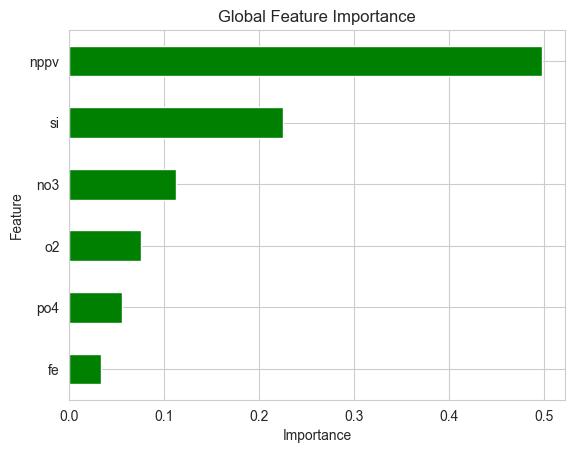

In [36]:
rf_1 = RandomForestRegressor(n_estimators=100, random_state=31)
rf_1.fit(chl_train[features], chl_train.chl)
global_importances = pd.Series(rf_1.feature_importances_, index= features)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title('Global Feature Importance')

## Final cv and test RMSEs

In [37]:
pd.DataFrame({'Model':['Baseline (average)','Linear Regression','XgBoost','SVR','Random Forest']
              , 'cv RMSE':[base_av_rmse,m_model_lr_rmse,m_model_xg_rmse,m_model_svr_rmse,m_model_rf_rmse]
              ,'test RMSE':[base_test_rmse,reg_test_rsme,xgb_test_rsme,svr_test_rsme,rfr_test_rsme]
              ,'features':[features,m_model_lr,m_model_xg,m_model_svr,m_model_rf]
              }).style.set_caption(
                  'RMSE of the Models')

,Model,cv RMSE,test RMSE,features
0,Baseline (average),0.423052,0.448332,"['fe', 'no3', 'po4', 'si', 'nppv', 'o2']"
1,Linear Regression,0.191020,0.205611,"['fe', 'no3', 'po4', 'si', 'nppv', 'o2']"
2,XgBoost,0.069051,0.077782,"['fe', 'no3', 'po4', 'si', 'nppv', 'o2']"
3,SVR,0.194259,0.218273,"['no3', 'po4', 'si', 'o2']"
4,Random Forest,0.081760,0.102186,"['fe', 'no3', 'po4', 'si', 'o2']"


## Shap analysis

In [38]:
import shap
shap.initjs()

For the Shap analysis we are using the paramaters found through `Gridsearch` above

In [39]:
model_sh = xgb.XGBRegressor(learning_rate= 0.1, max_depth= 5, n_estimators= 500)
model_sh.fit(chl_train[features], chl_train.chl)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
# get shap values
explainer = shap.Explainer(model_sh)
shap_values = explainer(chl_train[features])
np.shape(shap_values.values)
# shap_values = explainer(X[0:100])

(3078, 6)

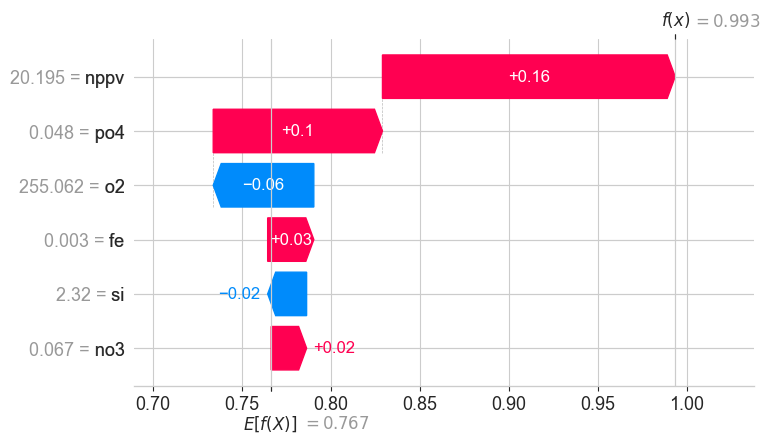

In [41]:
# waterfall plot for first observation
shap.plots.waterfall(shap_values[1])

In [42]:
# stacked force plot
shap.plots.force(shap_values[0:100])

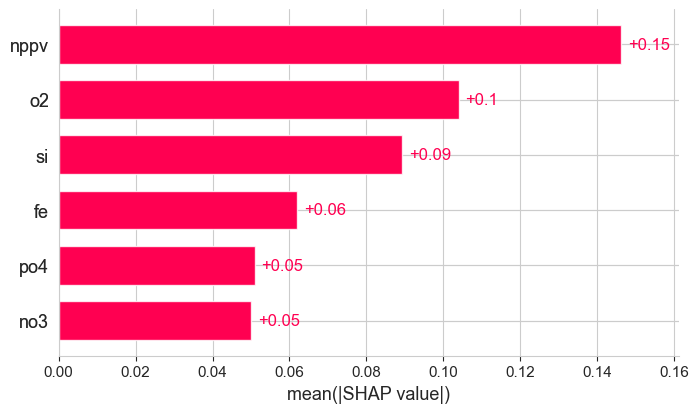

In [43]:
# mean SHAP
shap.plots.bar(shap_values)

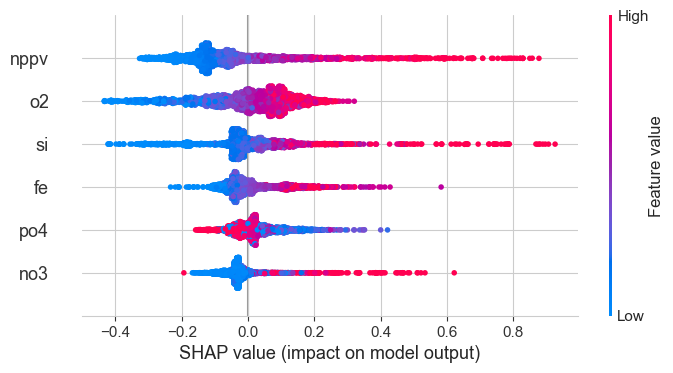

In [44]:
# beeswarm plot
shap.plots.beeswarm(shap_values)

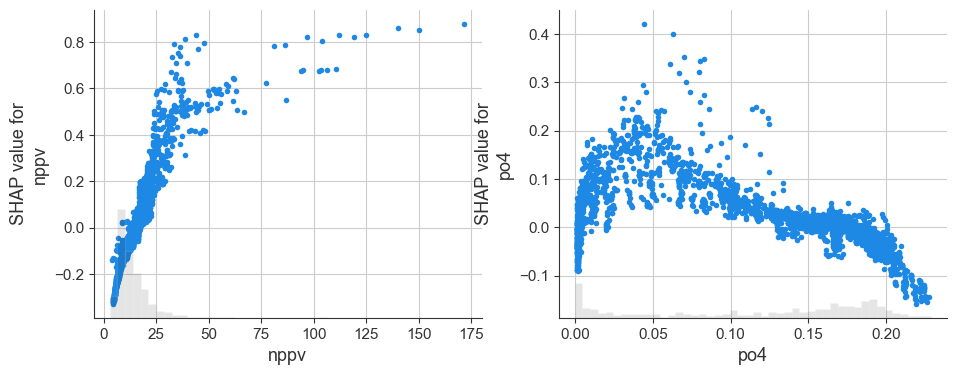

In [45]:
# plot 1: npvv
fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
shap.plots.scatter(shap_values[:, "nppv"],ax =axes[0],show=False)
shap.plots.scatter(shap_values[:, "po4"],ax =axes[1])